In [13]:
!pip install lpips
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import os
import glob
import time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
from sklearn.model_selection import train_test_split

# Initialize LPIPS metric
loss_fn_vgg = lpips.LPIPS(net='vgg').cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [14]:
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.pa(x)

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.ca(self.avg_pool(x))

class ResLayer(nn.Module):
    def __init__(self, channel):
        super(ResLayer, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 1, 1, 0, bias=True)
        self.in1 = nn.InstanceNorm2d(channel, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channel, channel, 3, 1, 1, bias=True)
        self.in2 = nn.InstanceNorm2d(channel, affine=True)
    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.in2(self.conv2(y))
        return self.relu(x + y)

class DehazeNet(nn.Module):
    def __init__(self, gps=3, dim=64):
        super(DehazeNet, self).__init__()
        self.gps, self.dim = gps, dim
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = nn.Conv2d(32, dim, 3, 1, 1)
        self.in2 = nn.InstanceNorm2d(dim, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResLayer(dim) for _ in range(7)])
        self.ca = CALayer(dim * gps)
        self.pa = PALayer(dim)
        self.conv3 = nn.Conv2d(dim, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 3, 3, 1, 1)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y1 = self.relu(self.in2(self.conv2(y)))
        y2 = self.res_blocks[:4](y1)
        y3 = self.res_blocks[4:](y2)

        concat = torch.cat([y1, y2, y3], dim=1)
        # Simplified CA logic for speed
        att = self.ca(concat)
        y = att[:, :self.dim, :, :] * y1 + att[:, self.dim:self.dim*2, :, :] * y2 + att[:, self.dim*2:, :, :] * y3
        y = self.pa(y)
        y = self.relu(self.conv3(y))
        return self.relu(x + self.conv4(y))

In [15]:
class IHazeDataset(Dataset):
    def __init__(self, gt_path, hazy_path, size=512):
        self.gt_images = sorted(glob.glob(os.path.join(gt_path, "*.jpg")) + glob.glob(os.path.join(gt_path, "*.png")))
        self.hazy_images = sorted(glob.glob(os.path.join(hazy_path, "*.jpg")) + glob.glob(os.path.join(hazy_path, "*.png")))
        self.size = size

    def __getitem__(self, index):
        gt = cv2.cvtColor(cv2.imread(self.gt_images[index]), cv2.COLOR_BGR2RGB)
        hazy = cv2.cvtColor(cv2.imread(self.hazy_images[index]), cv2.COLOR_BGR2RGB)
        gt = cv2.resize(gt, (self.size, self.size)) / 255.0
        hazy = cv2.resize(hazy, (self.size, self.size)) / 255.0
        return torch.from_numpy(gt).float().permute(2,0,1), torch.from_numpy(hazy).float().permute(2,0,1)

    def __len__(self):
        return len(self.gt_images)

# CONFIG PATHS
GT_PATH = "/content/dataset/I HAZY NTIRE 2018/GT"
HAZY_PATH = "/content/dataset/I HAZY NTIRE 2018/hazy"

full_dataset = IHazeDataset(GT_PATH, HAZY_PATH)
train_idx, temp_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=4, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=1)
test_loader = DataLoader(Subset(full_dataset, test_idx), batch_size=1)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 21, Val: 4, Test: 5


In [16]:
def compute_metrics(gt, pred):
    # gt, pred are (C, H, W) tensors in [0, 1]
    gt_np = gt.permute(1, 2, 0).cpu().numpy()
    pred_np = pred.permute(1, 2, 0).cpu().numpy()

    mse = np.mean((gt_np - pred_np) ** 2)
    psnr = peak_signal_noise_ratio(gt_np, pred_np, data_range=1.0)
    ssim = structural_similarity(gt_np, pred_np, data_range=1.0, channel_axis=-1)

    # LPIPS requires [-1, 1] range
    lpips_val = loss_fn_vgg(gt.unsqueeze(0).cuda() * 2 - 1, pred.unsqueeze(0).cuda() * 2 - 1).item()

    return mse, psnr, ssim, lpips_val

def visualize_results(model, loader, title, num_samples=10):
    model.eval()
    samples_shown = 0
    plt.figure(figsize=(20, 6))

    with torch.no_grad():
        for gt, hazy in loader:
            if samples_shown >= num_samples: break
            pred = model(hazy.cuda()).clamp(0, 1).cpu()

            # Plot Hazy
            plt.subplot(3, num_samples, samples_shown + 1)
            plt.imshow(hazy[0].permute(1,2,0))
            if samples_shown == 0: plt.ylabel("Hazy Input", fontsize=12)
            plt.axis('off')

            # Plot Pred
            plt.subplot(3, num_samples, num_samples + samples_shown + 1)
            plt.imshow(pred[0].permute(1,2,0))
            if samples_shown == 0: plt.ylabel("Prediction", fontsize=12)
            plt.axis('off')

            # Plot GT
            plt.subplot(3, num_samples, 2*num_samples + samples_shown + 1)
            plt.imshow(gt[0].permute(1,2,0))
            if samples_shown == 0: plt.ylabel("Ground Truth", fontsize=12)
            plt.axis('off')

            samples_shown += 1
    plt.suptitle(f"Results for {title} Set", fontsize=16)
    plt.tight_layout()
    plt.show()

Starting Training...
Epoch 1 Loss: 0.2491
Epoch 2 Loss: 0.2098
Epoch 3 Loss: 0.1482
Epoch 4 Loss: 0.1669
Epoch 5 Loss: 0.1647
Epoch 6 Loss: 0.1502
Epoch 7 Loss: 0.1457
Epoch 8 Loss: 0.1562
Epoch 9 Loss: 0.1306
Epoch 10 Loss: 0.1557

--- Training Metrics ---
MSE: 0.051338 | PSNR: 13.0840 | SSIM: 0.3415 | LPIPS: 0.5904


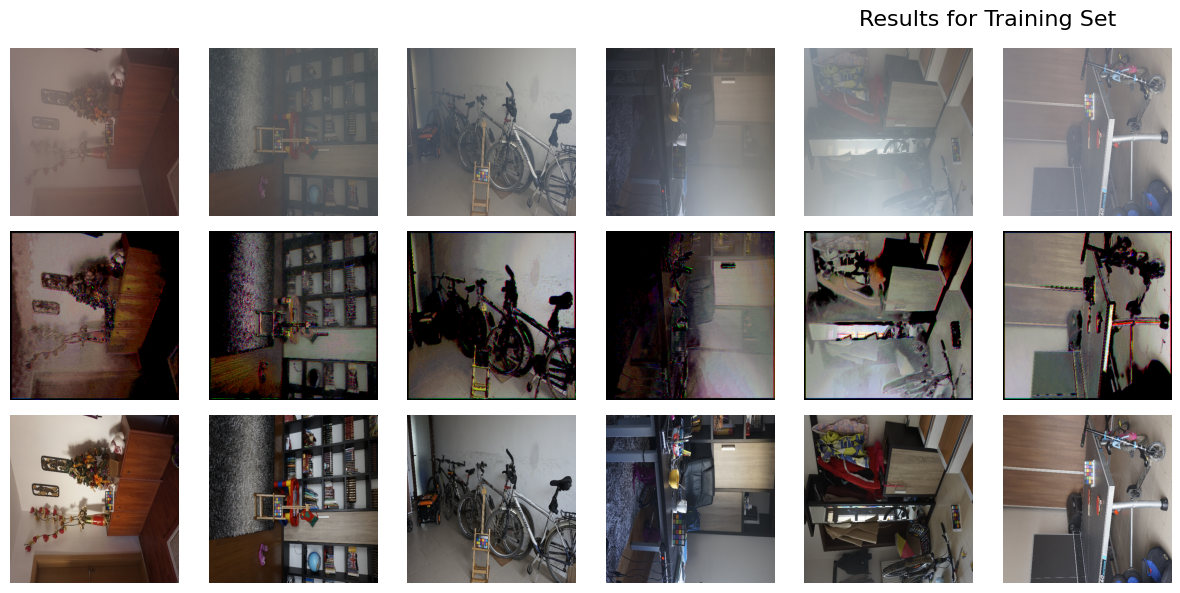


--- Validation Metrics ---
MSE: 0.059306 | PSNR: 12.5874 | SSIM: 0.3202 | LPIPS: 0.6165


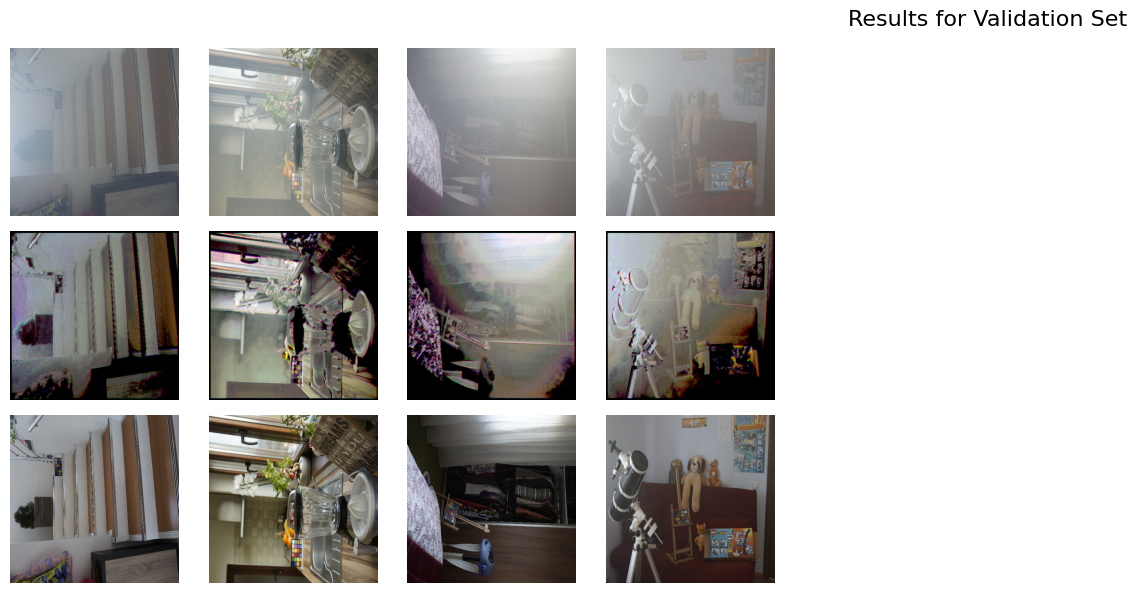


--- Testing Metrics ---
MSE: 0.042620 | PSNR: 13.7700 | SSIM: 0.3537 | LPIPS: 0.5733


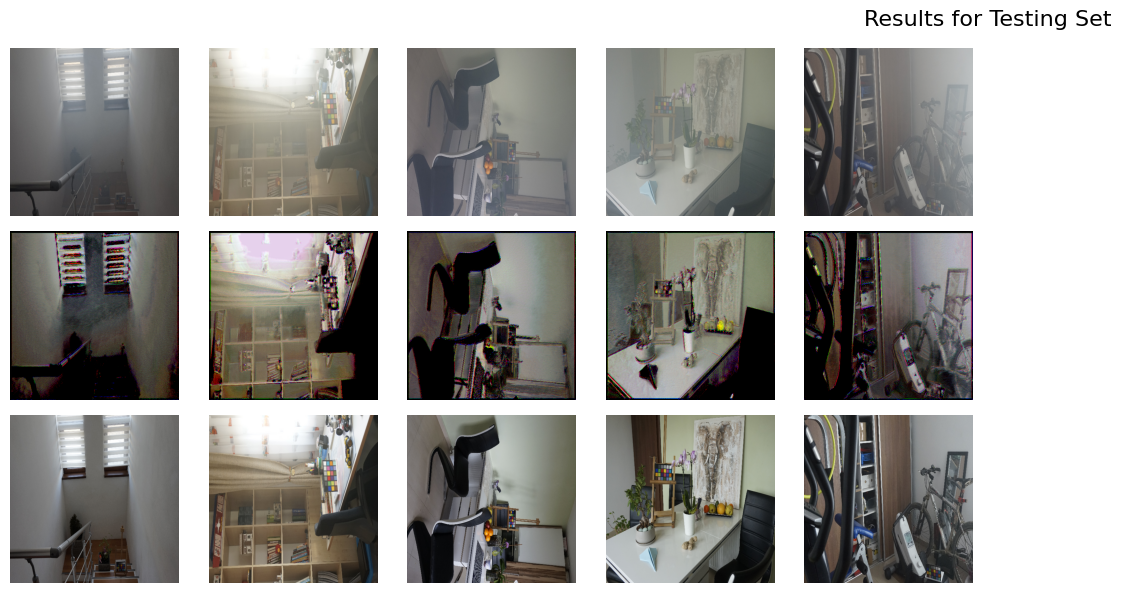

In [ ]:
device = torch.device("cuda")
model = DehazeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()


print("Starting Training...")
model.train()
for epoch in range(10): 
    for gt, hazy in train_loader:
        optimizer.zero_grad()
        out = model(hazy.to(device))
        loss = criterion(out, gt.to(device))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

# Evaluation Function
def evaluate_set(loader, name):
    avg_metrics = np.zeros(4)
    model.eval()
    with torch.no_grad():
        for gt, hazy in loader:
            pred = model(hazy.cuda()).clamp(0, 1)[0]
            m = compute_metrics(gt[0], pred.cpu())
            avg_metrics += np.array(m)
    avg_metrics /= len(loader)
    print(f"\n--- {name} Metrics ---")
    print(f"MSE: {avg_metrics[0]:.6f} | PSNR: {avg_metrics[1]:.4f} | SSIM: {avg_metrics[2]:.4f} | LPIPS: {avg_metrics[3]:.4f}")

# Final Execution
evaluate_set(train_loader, "Training")
visualize_results(model, train_loader, "Training")

evaluate_set(val_loader, "Validation")
visualize_results(model, val_loader, "Validation")

evaluate_set(test_loader, "Testing")
visualize_results(model, test_loader, "Testing")